In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from __future__ import print_function

In [2]:
import matplotlib.pyplot as plt
import copy
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
%matplotlib inline
from PIL import Image

In [4]:
device=torch.device('cpu')

In [5]:
imsize=128
loader=transforms.Compose([transforms.Resize(imsize),transforms.ToTensor()])

def image_loader(image_name):
    image=Image.open(image_name)
    #fake batch dimension required to fit network's dimensions
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

style_img=image_loader('picasso.jpg')
content_img=image_loader('dancing.jpg')
assert style_img.size() == content_img.size()  #size of content and style image should be the same

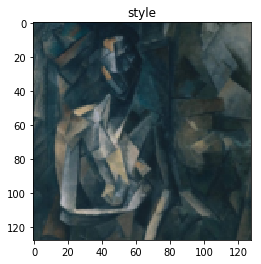

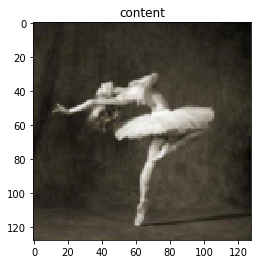

In [19]:
#plotting the images
unloader=transforms.ToPILImage() #reconvert into PIL image 
plt.ion()
def imshow(tensor,title=None):
    image=tensor.cpu().clone() #cloning the tensor to not make changes in it 
    image=image.squeeze(0)
    image=unloader(image)
    plt.imshow(image)
    if title is not None :
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img,title='style')
plt.figure()
imshow(content_img,title='content')

In [7]:
#content loss
class ContentLoss(nn.Module):
    
    def __init__(self,target):
        super(ContentLoss,self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target=target.detach()
        
    def forward(self,input):
        self.loss=F.mse_loss(input,self.target)
        return input
    
    
#style loss


def gram_matrix(input):
    a, b, c, d=input.size()
    #a=1 batch size
    #b=number of feature maps
    #c,d=size of image
    features=input.view(a * b,c * d) #reshaping activation
    G=torch.mm(features, features.t())
    #we normalize the values the values of the gram matrix
    #by dividing by the no of elements in the feature maps
    return G.div(a * b * c * d)


        
        
        
        
        

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn=models.vgg19(pretrained=True).features.to(device).eval() #to(device) to get the model to the device
 

In [10]:
cnn_normalization_mean=torch.tensor([0.485,0.456,0.406]).to(device)
cnn_normalization_std=torch.tensor([0.229,0.224,0.225]).to(device) 

In [11]:
#creating a module to normalize input images so that we can easily feed it to the sequential network
class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        #making the mean and std in the form of [C,1,1] to make it directly usable with img of B,C,H,W format
        self.mean=torch.tensor(mean).view(-1,1,1)
        self.std=torch.tensor(std).view(-1,1,1)
        
    def forward(self,img):
        #normalize image
        return (img-self.mean)/self.std
        
    

In [12]:
#desired depth layers to calculate content and style loss
content_layers_default=['conv_4']
style_layers_default=['conv_1','conv_2','conv_3','conv_4','conv_5']

In [13]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
            
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
            
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

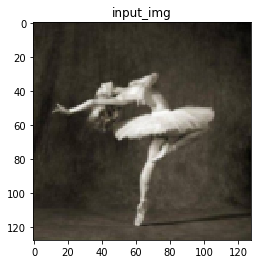

In [14]:
input_img=content_img.clone()
plt.figure()
image_show(input_img,title='input_img')

In [15]:
def get_input_optimizer(input_img):
    optimizer=optim.LBFGS([input_img.requires_grad_()])
    return optimizer
    

In [16]:
def run_style_transfer(cnn,normalization_mean,normalization_std,content_img,style_img,input_img,num_steps=300,
                       style_weight=1000000,content_weight=1):
    #run the style transfer
    print ('building the style transfer model')
    model,style_losses,content_losses=get_style_model_and_losses(cnn,normalization_mean,normalization_std,
                                                                 style_img,content_img)
    optimizer=get_input_optimizer(input_img)
    print ('optimizing...')
    run=[0]
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0,1)
            optimizer.zero_grad()
            model(input_img)
            style_score=0
            content_score=0
            for sl in style_losses:
                style_score+=sl.loss
            for cl in content_losses:
                content_score+=cl.loss  
            style_score*=style_weight
            content_score*=content_weight
            loss= style_score + content_score
            loss.backward()
            run[0]+=1
            if run[0]%50==0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            
            return style_score + content_score
        optimizer.step(closure) #closure used in optimizers like LBFGS
    
    input_img.data.clamp_(0,1)
    return input_img
        
            
        
            
        
        

In [21]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()


building the style transfer model
optimizing...
run [50]:
Style Loss : 2.452584 Content Loss: 9.480058

run [100]:
Style Loss : 2.215638 Content Loss: 8.876912

run [150]:
Style Loss : 2.019774 Content Loss: 8.319722

run [200]:
Style Loss : 1.839786 Content Loss: 7.918383

run [250]:
Style Loss : 1.753789 Content Loss: 7.582047

run [300]:
Style Loss : 1.680148 Content Loss: 7.341620



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

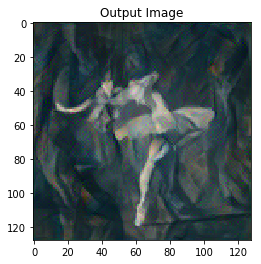

In [22]:
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()